# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science 



## Homework 6: Multilayer Feedforward Network - Dealing with Missing Data


**Harvard University**<br/>
**Fall 2018**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader

<hr style="height:2pt">

In [3]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the [instructions given in canvas](https://canvas.harvard.edu/courses/42693/pages/homework-policies-and-submission-instructions).

- This homework can be submitted in pairs.

- If you submit individually but you have worked with someone, please include the name of your **one** partner below. 


**Names of person you have worked with goes here:**
<br><BR>

In [4]:
%matplotlib inline
import numpy as np
import numpy.random as nd
import pandas as pd
import math
import matplotlib.pyplot as plt

import os
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import Imputer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from IPython.display import display

<div class="theme"> Overview </div>

In this homework, you are free to explore different ways of solving the problems -within the restrictions of the questions. Your solutions should read like a report with figures to support your statements. Please include your code cells as usual but augment your solutions with written answers. We will also check for code readability and efficiency as we feel you have some experience now. In particular, for Q1, we expect you to write appropriate functions, such as your code can be generalized beyond the specified network architectures of his homework.

For this homework you may **not** use a machine learning library such as `keras` or `tensorflow` to build and fit the network. The objective is to build the network equations from scratch.

- Q1 explores approximating a function using a **Multilayer Feedforward Network** with one input layer, one hidden layer, and one output layer. 

- Q2 deals with missing data in a medical dataset.

<div class="exercise"> <b> Question 1: Construct a feed forward neural network [50 pts]</b> </div>
    
In this part of the homework you are to construct three feed forward neural networks consisting of an input layer, one hidden layer with 1, 2 and 4 nodes respectively, and an output layer.  The hidden layer uses the sigmoid as the activation function and use a linear  output node. 
You should code the equations from scratch. 

You are given three datasets containing ($x,y$) points where $y=f(x)$:

- In the first dataset, $f(x)$ is a **single step** function (data in`data/step_df.csv`), 
- In the second dataset, $f(x)$ is a **one hump** function (data in `data/one_hump_df.csv`),
- In the third dataset, $f(x)$ is a **two equal humps** function (data in `data/two_hump_df.csv`).

**1.1** Create a plot of each dataset and explore the structure of the data. 

**1.2**  Give values to the weights **manually**, perform a forward pass using the data for the **single step** function and a hidden layer of **one** node, and plot the output from the network, in the same plot as the true $y$ values. Adjust the weigths (again manualy) until the plots match as closely as possible.

**1.3** Do the same for the **one hump** function data, this time using a hidden layer consisting of **two** nodes.

**1.4** Do the same for the **two hump** function data but this time increase the number of hidden nodes to **four**.  

**1.5** Choose the appropriate loss function and calculate and report the loss from all three cases. Derive the gradient of the output layer's weights for all three cases (step, one hump and two humps). Use the weights for the hidden layers you found in the previous question and perform gradient descent on the weights of this layer (output layer). What is the optimised weight value and loss you obtained? How many steps did you take to reach this value? What is the threshold value you used to stop? 

### Answers

**1.1** 

**Single Step Data**

In [5]:
# your code here
single_step = pd.read_csv('./data/step_df.csv')
single_step.head()

,x,y
0,-2.762886,0.000706
1,1.108371,-0.000376
2,-0.793581,-0.002845
3,-3.666329,-0.000031
4,8.805071,1.001807


Text(0.5,1,'Single Step Data')

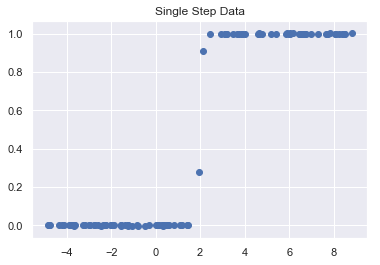

In [6]:
plt.scatter(single_step.x, single_step.y)
plt.title('Single Step Data')

**One Hump Data**

In [7]:
one_hump = pd.read_csv('./data/one_hump_df.csv')
one_hump.head()

,x,y
0,3.734197,1.000226
1,6.890217,-0.000877
2,3.330365,0.999072
3,-4.250132,-0.000071
4,3.700311,1.002423


Text(0.5,1,'One Hump Data')

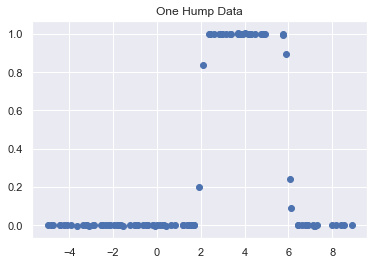

In [8]:
plt.scatter(one_hump.x, one_hump.y)
plt.title("One Hump Data")

**Two Hump Data**

In [9]:
# your code here
two_hump = pd.read_csv('./data/two_hump_df.csv')
two_hump.head()

,x,y
0,-2.637720,0.000288
1,3.808384,0.000326
2,3.121579,0.080294
3,5.713059,1.000351
4,3.975868,0.000362


Text(0.5,1,'Two Hump Data')

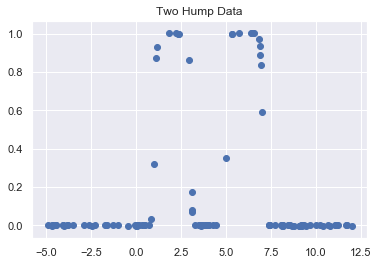

In [10]:
plt.scatter(two_hump.x, two_hump.y)
plt.title('Two Hump Data')

**Analysis**

In all three of the data sets, there is a strong non-linear relationship between the x and y variables.

**Coding the Neural Network**

In [51]:
class MLP(object):
    def __init__(self, input_nodes, hidden_nodes):
        self.l1_matrix = np.random.rand(input_nodes + 1, hidden_nodes)
        self.l2_matrix = np.random.rand(hidden_nodes+1, 1)
    
    def set_l1(self, new_param):
        if new_param.shape != self.l1_matrix.shape:
            raise ValueError("New parameters must be dimension {}".format(self.l1_matrix.shape))
        self.l1_matrix = new_param
    
    def set_l2(self, new_param):
        if new_param.shape != self.l2_matrix.shape:
            raise ValueError("New parameters must be dimension {}".format(self.l2_matrix.shape))
        self.l2_matrix = new_param
        
    def predict(self, x):
        # define sigmoid
        sigmoid = lambda x: 1/(1+np.exp(-x))
        
        # add bias to x
        x = np.array(x)
        x = x.reshape(-1,1)
        x = np.append(x, np.ones((x.shape[0],1)), axis = 1)
        
        # run forward mode
        self.layer_1 = x.dot(self.l1_matrix)
        self.activation_1 = sigmoid(self.layer_1)
        self.activation_1 = np.append(self.activation_1, np.ones(self.activation_1.shape[0]).reshape(-1,1), axis = 1)
        self.layer_2 = self.activation_1.dot(self.l2_matrix)
        return self.layer_2
    
    def loss(self, x, y):
        y_hat = self.predict(x)
        y = y.values.reshape(-1,1)
        return np.mean((y-y_hat)**2)
        
    def grad(self, x, y):
        y_hat = self.predict(x)
        y = y.values.reshape(-1,1)
        grad = np.mean(-2*(y-y_hat)*self.activation_1, axis = 0)
        return grad.reshape(-1,1)
        
    def optimize_layer_2(self, x, y, epochs, lr, threshold = 1e-5):
        e = 0
        while e < epochs and self.loss(x, y) > threshold:
            grad = self.grad(x, y)
            self.set_l2(self.l2_matrix - lr*grad)
            e += 1
        print('converged in {} epochs'.format(e))

**1.2** 

In [52]:
# initialize network
network_step = MLP(1, 1)
new_l1 = np.array([20,-40]).reshape(2,1)
network_step.set_l1(new_l1)
new_l2 = np.array([2,0]).reshape(2,1)
network_step.set_l2(new_l2)

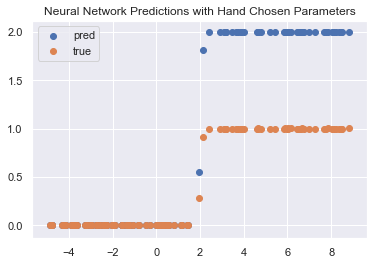

In [53]:
plt.scatter(single_step.x, network_step.predict(single_step.x), label = 'pred')
plt.scatter(single_step.x, single_step.y, label = 'true')
plt.legend()
plt.title("Neural Network Predictions with Hand Chosen Parameters")
plt.show()

**1.3** 

In [57]:
# initialize network
network_one_hump = MLP(1, 2)
new_l1 = np.array([[20,20],[-40,-120]])
network_one_hump.set_l1(new_l1)
new_l2 = np.array([2,-2,0]).reshape(3,1)
network_one_hump.set_l2(new_l2)

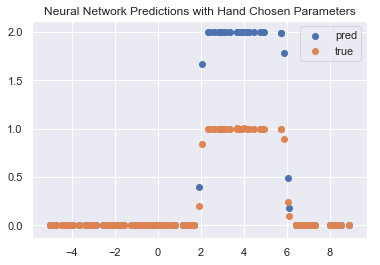

In [58]:
plt.scatter(one_hump.x, network_one_hump.predict(one_hump.x), label = 'pred')
plt.scatter(one_hump.x, one_hump.y, label = 'true')
plt.legend()
plt.title("Neural Network Predictions with Hand Chosen Parameters")
plt.show()

**1.4**

In [60]:
# initialize network
network_two_hump = MLP(1, 4)
new_l1 = np.array([[20,20,20,20],[-20,-60,-100,-140]])
network_two_hump.set_l1(new_l1)
new_l2 = np.array([2,-2,2,-2,0]).reshape(5,1)
network_two_hump.set_l2(new_l2)

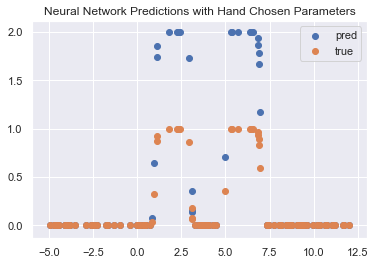

In [61]:
plt.scatter(two_hump.x, network_two_hump.predict(two_hump.x), label = 'pred')
plt.scatter(two_hump.x, two_hump.y, label = 'true')
plt.legend()
plt.title("Neural Network Predictions with Hand Chosen Parameters")
plt.show()

**1.5** 
Choose the appropriate loss function and calculate and report the loss from all three cases. 

I chose to implement a mean squared loss function

Hence, the gradient of the output layer's weights for all three cases (step, one hump and two humps) is $\nabla L_2 = 1/n\sum_{i=1}^n\left(-2(y_i-\hat{y_i})*\sigma(X_iL_1)\right)$

The threshold value I'm using is 1e-5.

**Gradient Descent Single Step**

In [62]:
network_step.optimize_layer_2(single_step.x, single_step.y, 10000, 0.1)
print('Layer 2 parameters')
network_step.l2_matrix

converged in 122 epochs
Layer 2 parameters


array([[ 1.00581744],
       [-0.00314928]])

In [63]:
network_one_hump.optimize_layer_2(one_hump.x, one_hump.y, 10000, 0.1)
print('Layer 2 parameters')
network_one_hump.l2_matrix

converged in 283 epochs
Layer 2 parameters


array([[ 1.00545105],
       [-1.00848556],
       [-0.00109126]])

In [64]:
network_two_hump.optimize_layer_2(two_hump.x, two_hump.y, 10000, 0.1)
print('Layer 2 parameters')
network_two_hump.l2_matrix

converged in 889 epochs
Layer 2 parameters


array([[ 1.01116114],
       [-1.01408857],
       [ 1.00698042],
       [-1.00331341],
       [-0.00106433]])

From these results, we can see that it takes more epochs for gradient descent to converge when the there are more parameters in the model.

<div class="exercise"> <b> Question 2: Working with missing data. [50 pts]</b> </div>

In this exercise we are going to use the **Pima Indians onset of diabetes** dataset found in `pima-indians-diabetes.csv`. This dataset describes patient medical record data for Pima Indians and whether they had an onset of diabetes within five years. It is a binary classification problem (onset of diabetes as 1 or not as 0). The input variables that describe each patient are numerical and have varying scales. The list below shows the eight attributes plus the target variable for the dataset:

- Number of times pregnant.
- Plasma glucose concentration a 2 hours in an oral glucose tolerance test.
- Diastolic blood pressure (mm Hg).
- Triceps skin fold thickness (mm).
- 2-Hour serum insulin (mu U/ml).
-  Body mass index.
-  Diabetes pedigree function.
- Age (years).<br>
- **Outcome** (1 for early onset of diabetes within five years, 0 for not), target class.

**2.1. Load the dataset into a pandas dataframe named `pima_df`. Clean the data by looking at the various features and making sure that their values make sense. Look for missing data including disguised missing data. The problem of disguised missing data arises when missing data values are not explicitly represented as such, but are coded with values that can be misinterpreted as valid data. Comment on your findings.**

In [88]:
pima_df = pd.read_csv('./data/pima-indians-diabetes.csv')
pima_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [89]:
pima_df.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                      object
dtype: object

It's strange that `Outcome` is type object. Let's investigate further.

In [90]:
pima_df.Outcome.unique()

array(['1', '0', '0\\', '1\\', '0}'], dtype=object)

I'm assuming that these are data entry errors - I will remove the slashes and brackets

In [91]:
pima_df.Outcome = pima_df.Outcome.apply(lambda x : x[0]).astype('category')
pima_df.Outcome.unique()

[1, 0]
Categories (2, object): [1, 0]

Much better! Now let's turn our attention to the predictors.

In [92]:
pima_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,764.000000,764.000000,764.000000,764.000000,764.000000,764.000000,764.000000,764.000000
mean,3.853403,120.922775,69.111257,20.537958,80.070681,31.998429,0.472712,33.248691
std,3.374327,32.039835,19.403339,15.970234,115.431087,7.899591,0.331981,11.771901
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.242500,24.000000
50%,3.000000,117.000000,72.000000,23.000000,34.000000,32.000000,0.375500,29.000000
75%,6.000000,141.000000,80.000000,32.000000,128.250000,36.600000,0.627500,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


There are two issues that deserve further investigating.

1. `Glucose`, `BloodPressure`, `SkinThickness`, `Insulin`, and `BMI` should never be 0, yet they all have min 0.
2. `Glucose`, `BloodPressure`, `SkinThickness`, `Insulin`, and `BMI` have high maximums and these outliers might be errors.

/Users/joshfeldman/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


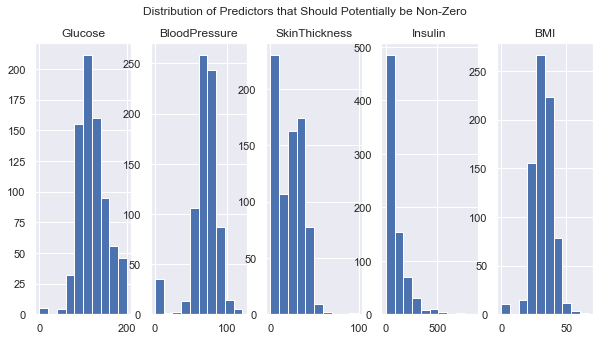

In [93]:
fig, axes = plt.subplots(1,5, figsize=(10,5))
non_zero_col = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for idx, ax in enumerate(axes):
        col = non_zero_col[idx]
        if col != "Outcome":
            ax.hist(pima_df[col])
            ax.set_title(col)
fig.suptitle("Distribution of Predictors that Should Potentially be Non-Zero")
fig.show()

These predictors seem to have an abnormal number of zeros, which makes me think that zeros are indeed missing values. I will replace them with `None`

In [94]:
non_zero_columns = ['Glucose', 'BloodPressure','SkinThickness', 'Insulin', 'BMI']
pima_df[non_zero_columns] = pima_df[non_zero_columns].replace(0,np.nan)
pima_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,764.000000,759.000000,729.000000,538.000000,393.000000,753.00000,764.000000,764.000000
mean,3.853403,121.719368,72.429355,29.165428,155.659033,32.46587,0.472712,33.248691
std,3.374327,30.597938,12.406940,10.502130,118.906865,6.93688,0.331981,11.771901
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.20000,0.078000,21.000000
25%,1.000000,99.000000,64.000000,22.000000,76.000000,27.50000,0.242500,24.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.30000,0.375500,29.000000
75%,6.000000,141.000000,80.000000,36.000000,190.000000,36.60000,0.627500,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.10000,2.420000,81.000000


The minimum values now make more sense. The maximum values do not seem completely out of the ordinary, so I will leave them as is.

**2.2 Split the dataset into a 75-25 train-test split (use `random_state=9001`). Fit a logistic regression classifier to the training set and report the  accuracy of the classifier on the test set. You should use $L_2$ regularization in logistic regression, with the regularization parameter tuned using cross-validation (`LogisticRegressionCV`).  Report the overall classification rate.**

In [95]:
def get_train_and_test_acc(df, impute):
    # create a training and test set
    print("Creating train and test sets...")
    pima_train, pima_test = train_test_split(pima_df, random_state=9001)
   
    # handle missing values
    print("Imputing missing values...")
    pima_train_impute, pima_test_impute = impute(pima_train, pima_test)
  
    print("Size of training data after imputation:",len(pima_train_impute))
    print("Size of test data after imputation:",len(pima_test_impute))
    #split into predictors and labels
    print("Preprocessing data")
    pima_train_X = pima_train_impute.drop("Outcome", axis = 1)
    pima_train_y = pima_train_impute["Outcome"]

    pima_test_X = pima_test_impute.drop("Outcome", axis = 1)
    pima_test_y = pima_test_impute["Outcome"]
    
    # we need to scale the data to ensure the l2 regularization performs better
    scaler = StandardScaler().fit(pima_train_X)
    pima_train_X_scaled = scaler.transform(pima_train_X)

    # fit logistic regression with L2 penalty
    print("Fitting model...")
    model = LogisticRegressionCV().fit(pima_train_X_scaled, pima_train_y)
    print("The accuracy on the training set is", accuracy_score(pima_train_y, model.predict(pima_train_X_scaled)))
    
    # report the accuracy on the test set
    pima_test_X_scaled = scaler.transform(pima_test_X)
    print("The accuracy on the test set is", accuracy_score(pima_test_y, model.predict(pima_test_X_scaled)))
    return (model.coef_, model.intercept_)

In [96]:
def impute_drop(df_train, df_test):
    df_train = df_train.dropna()
    dt_test = df_test.dropna()
    return df_train, dt_test

In [97]:
coefs_drop = get_train_and_test_acc(pima_df, impute_drop)

Creating train and test sets...
Imputing missing values...
Size of training data after imputation: 287
Size of test data after imputation: 104
Preprocessing data
Fitting model...
The accuracy on the training set is 0.7804878048780488
The accuracy on the test set is 0.7692307692307693


**2.3 Restart with a fresh copy of the whole dataset and impute the missing data via mean imputation.  Split the data 75-25 (use `random_state=9001`) and fit a regularized logistic regression model.  Report the overall classification rate.**

In [98]:
def impute_mean(df_train, df_test):
    predictors = df_train.drop('Outcome',axis =1).columns
    df_train[predictors] = df_train[predictors].fillna(df_train[predictors].mean())
    df_test[predictors] = df_test[predictors].fillna(df_train[predictors].mean())
    return df_train, df_test

In [99]:
coefs_mean = get_train_and_test_acc(pima_df, impute_mean)

Creating train and test sets...
Imputing missing values...


/Users/joshfeldman/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


Size of training data after imputation: 573
Size of test data after imputation: 191
Preprocessing data
Fitting model...
The accuracy on the training set is 0.7731239092495636
The accuracy on the test set is 0.7591623036649214


**2.4** Again restart with a fresh copy of the whole dataset and impute the missing data via a model-based imputation method. Once again split the data 75-25 (same `random_state=9001`) and fit a regularized logistic regression model.  Report the overall classification rate.

For the model-based inputation, we will use the rows for which we have no missing values to train KNN predictors. For each combination of missing and non-missing covariates in the dataset, we will train a KNN predictor to impute the missing elements.

In [100]:
from sklearn.neighbors import KNeighborsRegressor

In [101]:
def get_missing_in_row(row):
    row_na = row.isna()
    row_na_names = row[row_na].index
    return row_na_names    

In [102]:
def fit_KNN(missing_col, all_missing_cols, df_train):
    df_train_X = (df_train
                  .dropna()
                  .drop('Outcome', axis = 1)
                  .drop(all_missing_cols, axis = 1)
                 )
    df_train_y = (df_train
                  .dropna()
                  [missing_col]
                 )
    model = KNeighborsRegressor(n_neighbors = 2).fit(df_train_X, df_train_y)
    return model

In [103]:
def impute_KNN_single_df(df_to_impute, df_train):
    count = 0
    models = {}
    for idx, row in df_to_impute.iterrows():
        if count % 10 == 0:
            print("Imputed {}/{}".format(count, len(df_to_impute)))
        all_missing_cols = list(get_missing_in_row(row))
        for missing_col in all_missing_cols:
            if str(missing_col) + str(all_missing_cols) in models.keys():
                model = models[str(missing_col) + str(all_missing_cols)]
            else:
                model = fit_KNN(missing_col, all_missing_cols, df_train)
                models[str(missing_col) + str(all_missing_cols)] = model
            value_to_impute = model.predict(row
                                            .drop('Outcome')
                                            .drop(all_missing_cols)
                                            .values
                                            .reshape(1,-1)
                                            )
            row[missing_col] = value_to_impute[0]
        df_to_impute.loc[idx] = row
        count += 1
    return df_to_impute

In [104]:
def impute_KNN(df_train, df_test):
    print("Imputing training data...")
    df_train = impute_KNN_single_df(df_train, df_train)
    print("Imputing testing data...")
    dt_test = impute_KNN_single_df(df_test, df_train)
    return df_train, dt_test

In [105]:
coefs_knn = get_train_and_test_acc(pima_df, impute_KNN)

Creating train and test sets...
Imputing missing values...
Imputing training data...
Imputed 0/573


/Users/joshfeldman/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Imputed 10/573
Imputed 20/573
Imputed 30/573
Imputed 40/573
Imputed 50/573
Imputed 60/573
Imputed 70/573
Imputed 80/573
Imputed 90/573
Imputed 100/573
Imputed 110/573
Imputed 120/573
Imputed 130/573
Imputed 140/573
Imputed 150/573
Imputed 160/573
Imputed 170/573
Imputed 180/573
Imputed 190/573
Imputed 200/573
Imputed 210/573
Imputed 220/573
Imputed 230/573
Imputed 240/573
Imputed 250/573
Imputed 260/573
Imputed 270/573
Imputed 280/573
Imputed 290/573
Imputed 300/573
Imputed 310/573
Imputed 320/573
Imputed 330/573
Imputed 340/573
Imputed 350/573
Imputed 360/573
Imputed 370/573
Imputed 380/573
Imputed 390/573
Imputed 400/573
Imputed 410/573
Imputed 420/573
Imputed 430/573
Imputed 440/573
Imputed 450/573
Imputed 460/573
Imputed 470/573
Imputed 480/573
Imputed 490/573
Imputed 500/573
Imputed 510/573
Imputed 520/573
Imputed 530/573
Imputed 540/573
Imputed 550/573
Imputed 560/573
Imputed 570/573
Imputing testing data...
Imputed 0/191
Imputed 10/191
Imputed 20/191
Imputed 30/191
Imputed 40/19

**2.5 Compare the results in the 3 previous parts of this problem.  Prepare a paragraph (5-6 sentences) discussing the results, the computational complexity of the methods,  and explain why you get the results that you see.**

For all three of the imputation methods, we achieve a test set accuracy of 76%. This might be because the missing values are missing completely at random. When data is missing completely at random, our remaining dataset is a representative sample of the original data. Mean and model based imputation shouldn't introduce any bias and lead to a similar result as simply dropping the rows with missing data. 

Unfortunately, without knowing anything about how the data was collected or the underlying true data generating processes, we cannot test this hypothesis.

The model based imputation was much slower than the other methods.

**2.6 This question does not have one answer and requires some experimentation. Check which coefficients changed the most between the model in 2.1-2.2 and the models in 2.3 and 2.4. Are they the coefficients you expected to change given the imputation you performed? If not explain why (supporting your explanation using the data is always a good idea).**

In [106]:
drop = list(coefs_drop[0][0])
drop.append(coefs_drop[1][0])
mean = list(coefs_mean[0][0])
mean.append(coefs_mean[1][0])
knn = list(coefs_knn[0][0])
knn.append(coefs_knn[1][0])

coefs_df = pd.DataFrame([drop,mean,knn])
covariates = list(pima_df.columns[:-1])
covariates.append("intercept")
coefs_df.columns = covariates
coefs_df.index = ['drop', 'mean', 'knn']

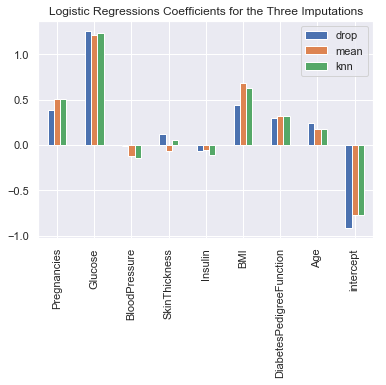

In [107]:
coefs_df.T.plot(kind = 'bar')
plt.title('Logistic Regressions Coefficients for the Three Imputations')
plt.show()

We should expect the coefficients resulting from mean or model-based imputation to differ from the coefficients attained through drop imputation. When we drop samples with missing data, it makes our dataset smaller, leading to a larger standard error on our coefficients. This means that for drop imputation there is a greater probability that the estimated coefficients are further from the true coefficients. Alternatively, mean imputation and model-based imputation should lead to estimates closer to the true coefficients. We see this in the graph above, with the mean and model-based imputation giving similar results, whereas drop imputation gives different estimates.

This analysis, however, rests upon the assumption that our imputation method does not introduce bias in our estimates. This is almost certainly not the case, but as mentioned above, without knowledge of how the data was collected or the data generating process we cannot assess this claim.

It does appear, however, that blood pressure, skin thickness, and insulin are not related to the onset of diabetes (all the models, regardless of the imputation method, have blood pressure, skin thickness, and insulin coefficients close to zero).